### Google Cloud Storage in Zarr format : Benchmark

Notes
- tests_2 and 3 were done with small chunk size of just 13.
- tests_4 and 5 were done with a large chunk size of 9030

In [1]:
import numpy as np
from contextlib import contextmanager
import intake
import time
#import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import s3fs
import xarray as xr
import dask
import fsspec
import zarr
import dask.array as dsa
import pandas as pd

endpoint_url = "https://mghp.osn.xsede.org"
bucket = 'cnh-bucket-1'


In [3]:
gcs_url = 'pangeo-ecco-llc4320/ssh'
fs_gcs = fsspec.get_filesystem_class('gs')(requester_pays=True)
gcs_mapper = fs_gcs.get_mapper(gcs_url)

In [4]:
zgroup = zarr.open_consolidated(gcs_mapper)
print(zgroup.info)

Name             : /
Type             : zarr.hierarchy.Group
Read-only        : False
Store type       : zarr.storage.ConsolidatedMetadataStore
Chunk store type : fsspec.mapping.FSMap
No. members      : 5
No. arrays       : 5
No. groups       : 0
Arrays           : Eta, face, i, j, time



In [5]:
array = zgroup['Eta']

In [6]:
array_dask = dask.array.from_zarr(array)
array_dask

,Array,Chunk
Bytes,8.76 TB,74.65 MB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,>f4,numpy.ndarray


In [7]:
%time _ = array_dask[0].compute()

CPU times: user 3.72 s, sys: 5.85 s, total: 9.57 s
Wall time: 5.82 s


## This is where I manually change the data for small v/s large chunk sizes. 

In [8]:
# For smaller chunk sizes I use a data set of about 75 GB with a 1000 chunks. Good for reading with upto 20 workers
data = array_dask[:1000,0,:]
data

dask.array<getitem, shape=(1000, 4320, 4320), dtype=>f4, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>

In [9]:
# For large chunk sizes I use a data set of about 675 GB with 9030 chunks. Good for reading with workers more than 20
#data = array_dask[:,0,:]
#data

dask.array<getitem, shape=(9030, 4320, 4320), dtype=>f4, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>

### Setting up Benchmarking

In [17]:
class DevNullStore:

    def __init__(self):
        pass

    def __setitem__(*args, **kwargs):
        pass

In [18]:
null_store = DevNullStore()
# this line produces no error but actually does nothing
null_store['foo'] = 'bar'

In [35]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()
cluster

In [36]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.7b155c3c04664c18a6055c274e66ba0e Dashboard: /services/dask-gateway/clusters/prod.7b155c3c04664c18a6055c274e66ba0e/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [37]:
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)

diag_timer = DiagnosticTimer()


In [38]:
chunksize = np.prod(data.chunksize) * data.dtype.itemsize
chunksize

74649600

In [39]:
def total_nthreads():
    return sum([v for v in client.nthreads().values()])

def total_ncores():
    return sum([v for v in client.ncores().values()])

def total_workers():
    return len(client.ncores())

### Running the tests

In [40]:
diag_kwargs = dict(nbytes=data.nbytes, chunksize=chunksize,
                   cloud='GCS', format='zarr')

# You can subset the number of workers from the list below
#1,1,2,2,4,4,6,7,8,9,15,16,20,25,30,35,40,45,50,55,60,70
for nworkers in [1,1,2,2,4,4,6,7,8,9,15,16]:
    cluster.scale(nworkers)
    time.sleep(10)
    client.wait_for_workers(nworkers)
    print(nworkers)
    with diag_timer.time(nthreads=total_nthreads(),
                         ncores=total_ncores(),
                         nworkers=total_workers(),
                         **diag_kwargs):

        future = dsa.store(data, null_store, lock=False, compute=False)
        dask.compute(future, retries=5)



1
1
2
2
4
4
6
7
8
9
15
16


In [41]:
client.close()
cluster.close()

### Looking at results and saving files

In [42]:
df = diag_timer.dataframe()
df

,nthreads,ncores,nworkers,nbytes,chunksize,cloud,format,runtime
0,2,2,1,74649600000,74649600,GCS,zarr,246.248305
1,2,2,1,74649600000,74649600,GCS,zarr,246.217311
2,4,4,2,74649600000,74649600,GCS,zarr,123.881029
3,4,4,2,74649600000,74649600,GCS,zarr,120.625151
4,8,8,4,74649600000,74649600,GCS,zarr,67.490466
5,8,8,4,74649600000,74649600,GCS,zarr,67.785261
6,12,12,6,74649600000,74649600,GCS,zarr,46.045425
7,14,14,7,74649600000,74649600,GCS,zarr,38.660186
8,16,16,8,74649600000,74649600,GCS,zarr,35.406102
9,18,18,9,74649600000,74649600,GCS,zarr,33.271620


<AxesSubplot:xlabel='ncores'>

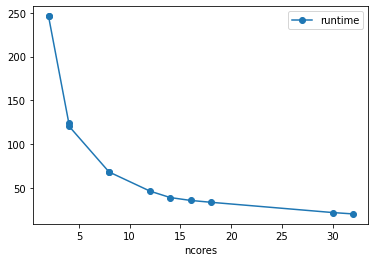

In [43]:
df.plot(x='ncores', y='runtime', marker='o')

<AxesSubplot:xlabel='ncores'>

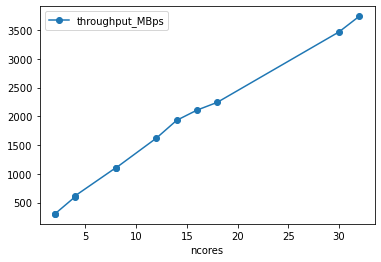

In [44]:
df['throughput_MBps'] = df.nbytes / 1e6 / df['runtime']
df.plot(x='ncores', y='throughput_MBps', marker='o')

<AxesSubplot:xlabel='nthreads'>

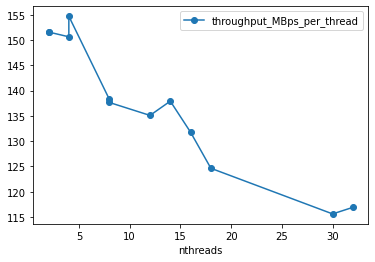

In [45]:
df['throughput_MBps_per_thread'] = df.throughput_MBps / df.nthreads
df.plot(x='nthreads', y='throughput_MBps_per_thread', marker='o')

In [46]:
df.to_csv('gcs_zarr_test-5_us_central.csv')

In [47]:
df

,nthreads,ncores,nworkers,nbytes,chunksize,cloud,format,runtime,throughput_MBps,throughput_MBps_per_thread
0,2,2,1,74649600000,74649600,GCS,zarr,246.248305,303.147671,151.573835
1,2,2,1,74649600000,74649600,GCS,zarr,246.217311,303.185831,151.592915
2,4,4,2,74649600000,74649600,GCS,zarr,123.881029,602.591056,150.647764
3,4,4,2,74649600000,74649600,GCS,zarr,120.625151,618.856015,154.714004
4,8,8,4,74649600000,74649600,GCS,zarr,67.490466,1106.076225,138.259528
5,8,8,4,74649600000,74649600,GCS,zarr,67.785261,1101.265954,137.658244
6,12,12,6,74649600000,74649600,GCS,zarr,46.045425,1621.216425,135.101369
7,14,14,7,74649600000,74649600,GCS,zarr,38.660186,1930.916753,137.922625
8,16,16,8,74649600000,74649600,GCS,zarr,35.406102,2108.382338,131.773896
9,18,18,9,74649600000,74649600,GCS,zarr,33.271620,2243.641892,124.646772
